# Simulate a Van Der Pol Oscillator
Generate initial condition and model

In [2]:
from scipy.integrate import odeint
from torchdiffeq import odeint as odeint_nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchdiffeq
import torch.nn.functional as F
from torch import nn

In [3]:
# define van der pol dynamics
def VDP(y, t):
    mu = 1
    x1, x2 = y
    dydt = [x2, mu * (1 - x1**2)*x2 - x1]
    return dydt

In [6]:
# define initial conditions and timespan
t = np.linspace(0, 10, 1001)
t = np.arange(0,5,0.01)
y0 = [1, 1]

# solve the system
sol = odeint(VDP, y0, t)


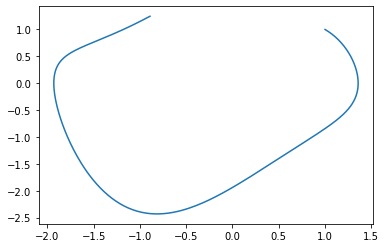

In [7]:
# plot the solution
plt.plot(sol[:, 0], sol[:, 1])
plt.show()

# Generate Training Data
Create a grid of trajectories from random initial conditions between [-2, -2] and [2, 2]


In [57]:
# try it for lots of initial conditions

# generate initial condition span
N = 5000
ti = 0
tf = 5
ts = 0.1
Y0 = np.random.rand(N,2) * 8 - 4
# t = np.linspace(ti,tf,ts)
t = np.arange(ti,tf,ts)

X = np.zeros((t.size,N,2))
dt_gt = t[1]

for i in range(N):
    y0 = Y0[i,:]
    sols = odeint(VDP, y0, t, rtol=1.5e-8, atol=1.5e-8)
    X[:,i,:] = sols
    
# Training data dimensioning: 
# X = [trajectory, experiment, (x,y)]
# X = [timespan length, N, 2]

50


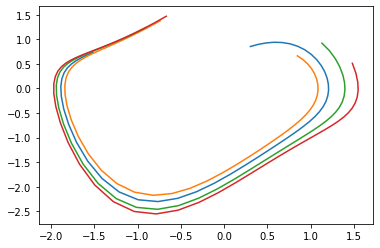

In [50]:
# plot a couple trajectories 

ic = np.random.randint(low=0,high=(N-1))
plt.plot(X[:,ic,0], X[:,ic, 1])
ic = np.random.randint(low=0,high=(N-1))
plt.plot(X[:,ic,0], X[:,ic, 1])
ic = np.random.randint(low=0,high=(N-1))
plt.plot(X[:,ic,0], X[:,ic, 1])
ic = np.random.randint(low=0,high=(N-1))
plt.plot(X[:,ic,0], X[:,ic, 1])




# Define the Network Model and Initialize Optimizer

In [51]:
# define network for Neural-ODE model
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.layer1 = nn.Linear(2, 64)
    self.act1 = nn.Tanh()
    self.layer2 = nn.Linear(64, 64)
    self.act2 = nn.Tanh()
    self.layer3 = nn.Linear(64, 2)

  def forward(self, t, x):
    x = self.layer1(x)
    x = self.act1(x)
    x = self.layer2(x)
    x = self.act2(x)
    x = self.layer3(x)
    
    return x

In [58]:
# define hyper-parameters
num_eval_pts = 101
tspan = np.linspace(0,10,num_eval_pts)
dt_nn = tspan[1]
tspan = torch.Tensor(tspan)

model = Network()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

numIter = 10000
loss_fn = nn.MSELoss()
loss_list = np.zeros((numIter,))
val_loss_list = np.zeros((int(numIter/100),))

# check tspan for pred matches the training data 
# in the future, potentially generate training data alongside the real data
print(dt_nn)
print(dt_gt)


0.1
0.1


In [59]:
# function for viewing intermedeate results 

def disp_pred(t,y0):
    y0_nn = torch.Tensor(y0);
    t_nn = torch.Tensor(t)
    sol = odeint(VDP, y0, t)
    with torch.no_grad():
        pred = odeint_nn(model,y0_nn,t_nn)
    # plot the solution
    plt.figure(1)
    plt.plot(sol[:, 0], sol[:, 1])
    plt.plot(pred[:, 0], pred[:, 1])
    plt.show()


In [60]:
# split train and validation data

X_train = X[:, :900, :]
X_val = X[:, 901:, :]

# Train the Model

In [66]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
N = 15000
num_eval_pts = 151
tspan = np.linspace(0,15,num_eval_pts)
dt_nn = tspan[1]
tspan = torch.Tensor(tspan)
print(dt_nn)
loss_list = np.zeros((numIter,))
val_loss_list = np.zeros((int(numIter/100),))

0.1


0.07607065886259079


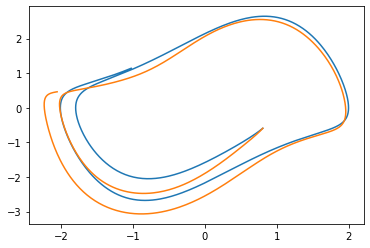

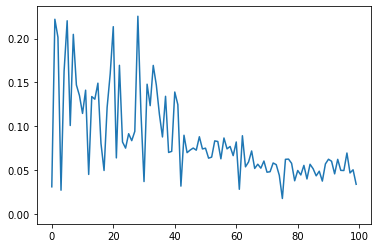

0.03817607834935188


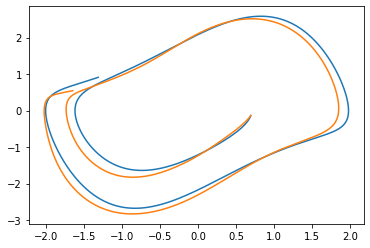

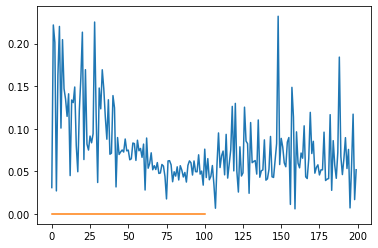

0.12597553431987762


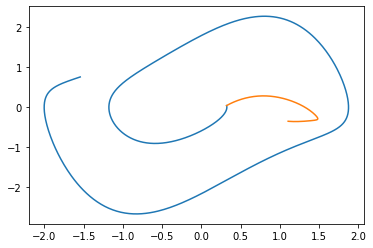

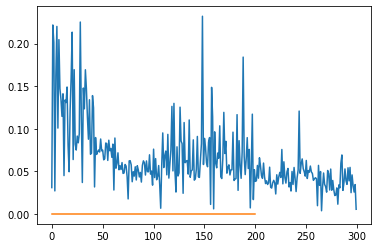

0.04718073457479477


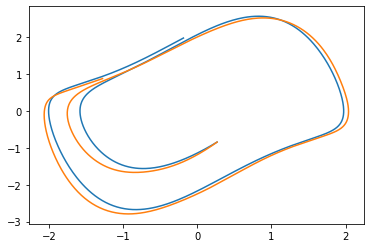

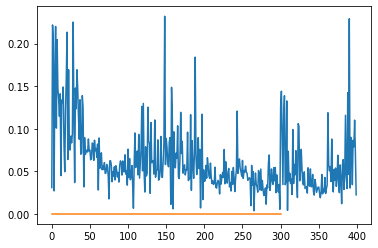

KeyboardInterrupt: 

In [67]:
for i in range(numIter):
    #for ic in range(N):
    optimizer.zero_grad()

    #idx1 = np.random.randint(low=0,high=(ts-num_eval_pts-1))
    #x0 = X_train[idx1,:,:]
    #x0 = torch.Tensor(x0)

    
   # tsapn = [np.zeros((N,1)), np.random.rand(N,1)]
    targets = np.zeros((2,N,2))

    x0 = np.random.rand(N,2) * 7 - 3.5
    tspan = [0, np.random.rand()]
    for ii in range(N):
        sols = odeint(VDP, x0[ii,:], tspan, rtol=1.5e-8, atol=1.5e-8)
        targets[:,ii,:] = sols

    targets = torch.Tensor(targets)

    # forward pass
    x0 = torch.tensor(x0)
    tspan = torch.tensor(tspan)
    pred = odeint_nn(model, x0.float(), tspan.float())

    # calculate loss
    #loss = loss_fn(pred[1:] - targets)

    loss = torch.mean(torch.abs(pred - targets))
    loss_list[i] = loss.item()

    # backwards pass
    loss.backward()
    optimizer.step()
    '''
    if (i % 100) == 0:
        print("loss : ",loss.item())
        with torch.no_grad():
            idx1 = np.random.randint(low=0,high=(ts-num_eval_pts-1))
            x0 = X_val[idx1,:,:]
            x0 = torch.Tensor(x0)
            targets = X_val[idx1+1:(idx1+num_eval_pts),:,:]
            targets = torch.Tensor(targets)
            pred = odeint_nn(model, x0, tspan)
            val_loss = torch.mean(torch.abs(pred[1:] - targets))
            val_loss_list[int(i/100)] = val_loss.item()
    '''
    if (i % 100) == 0:
        if i != 0:
            print(loss.item())
            t = np.linspace(0, 10, 1001)
            test_x0 = [np.random.rand() * 4 - 2, np.random.rand() * 4 - 2]
            disp_pred(t, test_x0)
            plt.figure(2)
            plt.plot(np.arange(0,i), loss_list[:i])
            plt.plot(np.arange(0,i,100), val_loss_list[:(int(i/100))])
            plt.show()

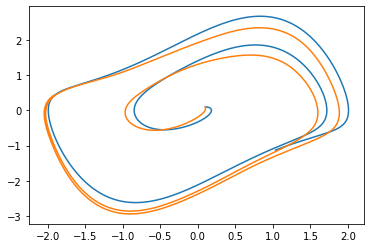

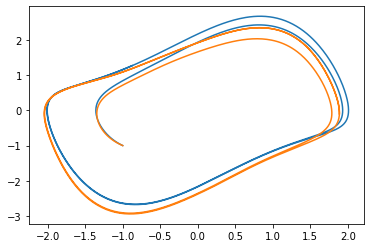

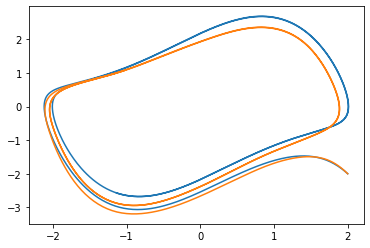

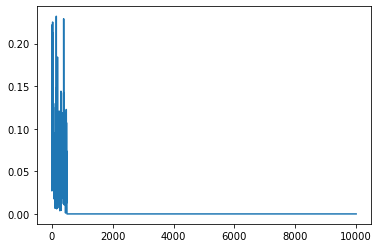

In [68]:
# define initial conditions and timespan
t = np.linspace(0, 15, 1501)
y0 = [0.1, 0.1]
disp_pred(t,y0)
y0 = [-1, -1]
disp_pred(t,y0)
y0 = [2, -2]
disp_pred(t,y0)

plt.plot(loss_list)